# **Project Management**

> 시시닥거리와 개발노트는 여기에, 밑에는 깔끔하고 extensible한 코드베이스 :)

> 7월 16일 쓰다가 무슨일인지 멈췄다, 8월 13일 재게.

**0. 목적: 코드베이스 깔끔화**

Live Braille. 2-3일을 쏟아부은 재밌는 프로젝트였지만, 아쉬운 점은 코드베이스가 스파게티화되어 더이상의 수정이 힘들어진 것. 버전업하며 최적화를 해결하고 효율적인 구조를 적용해 추후 기능추가를 수월하게, 또 다른 프로젝트에 융합가능한 모듈로서 매듭을 짓고자 한다.

**1. On Use of PaddleOCR.**

인식률과 런타임이 훌륭한 scene text detection 알고리즘은 PaddleOCR과 EasyOCR이 있다. 이중 PaddleOCR이 넘사벽으로 (6배가량) 빠르지만, 실행환경 셋업이 복잡한 단점을 가졌다. 정확히 말하자면, 무슨 이유인지, 공식 설치로는 버그가 있어 실행이 안되고, Conda로는 오래되고 인기없는 formulae에 의존해야 한다. Paddle이라는 중국발 딥러닝 프레임워크를 사용해야 하는것이 사실은 조금 싫지만, 사실 deployment를 고려한다면 내가 이 프레임워크를 배우고 딥러닝 에코시스템을 배우는건 좋은 점이기에, 후에 더 중요한 이유가 나오지 않는 한 PaddleOCR을 사용할 계획이다. 더 생각을 하기엔 시간이 아깝다.

→ 두시간 가량 삽질한 결과, 전체적인 그림을 이해하기 시작했다. Paddle은 훈련부터 Deployment를 모두 포함한 풀스택 DL 프레임워크고, 당연히 TRT와 같은 런타임 최적화를 포함한다. 다만 PaddleOCR도 준 production-level 급의 라이브러리로, 이미 상당히 최적화되어있다. [PaddleOCR의 TRT 성능 상승폭은 25% 가량이다.](https://github.com/PaddlePaddle/PaddleOCR/issues/6663#issuecomment-1162998567) `paddlepaddle-gpu` 대신 `paddle inference` (link in Pocket) 를 깔면 TRT를 쓸 수 있지만 Paddle측 유지보수가 똥이라 Docker를 배우거나, TensorRT 및 엔비디아 컴퓨터 툴킷에 대해 (특히 버전컨트롤) 공부해야만 쓸 수 있겠다. Docker는 local file immutability, camera stream 등의 문제로 생각치 않는 중이다. 이미 Paddle은 EasyOCR+TensorRT보다 빠르기 때문에, 현재 알고리즘으로 만족하고 개발 후 칼만도 배워볼겸, SORT 기반 최적화가 가능한지 생각하면 되겠다. 원론적으로 생각해보면, 매초 60번씩 OCR을 돌린다는건 넌센스고, 기억에 의존하는 것이 맞다. 사람도 그렇게 작동할 것이고.

CUDA/Conda/Paddle로 삽질하며 느낀 점들을 여기 적어보자. 이전의 PaddleOCR hang 문제는 내가 CUDA 버전에 맞지 않는 Paddlepaddle-gpu를 설치해서 그런 것이였다. 단순 PyPi/Conda 설치가 아닌, Paddle 웹사이트에 들어가니 PyTorch와 비슷하게 버전에 맞춘 custom wheel URL로 pip 설치 커맨드를 주더라. 허허. 엔비디아 이놈들때문에 여럿 고생한다.

**2. On Optimization.**

현재 최적화 아이디어는 역시나 칼만기반이 있다. OrCAM과 비슷한 기능을 구현하려면 environmental memory 시스템 또한 필요하다. 하지만 나는 앞으로 TensorRT를 배울 생각이며, Paddle에 TensorRT까지 더하면 속도가 무척 빠르기 때문에 지금으로썬 최적화를 보류하기로 했다. 

**3. SORT to Solve Temporal Misrecognition.**

# **0. Setup**

Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import dearpygui.dearpygui as dpg
import mediapipe as mp
import time

Setup

In [2]:
window_size = [1400, 800]
viz_res = tuple([400, 300])

# **1. Subcomponents**

Debug

In [3]:
# debug = True
debug = False
test_name = 'sign'

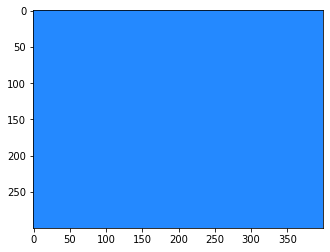

In [4]:
if debug: 
    img_raw = cv2.cvtColor(cv2.imread('./test_images/test_{}.jpg'.format(test_name)), cv2.COLOR_BGR2RGB)
else:
    cam = cv2.VideoCapture(0)
    _, img_raw = cam.read()

img = cv2.resize(img_raw, viz_res, interpolation=cv2.INTER_AREA)
# img_rgba = rgba(img)
plt.imshow(img)

Utils

In [5]:
def imdpg2(img):
    return img.astype(np.float32)/255

## **1A. Scene Text Detection**

In [6]:
from paddleocr import PaddleOCR, draw_ocr
# paddle = PaddleOCR(lang="en", debug=False, show_log=False)
paddle = PaddleOCR(lang="en", debug=False, show_log=False, use_angle_cls=True)

In [7]:
# test
result = paddle.ocr(img, cls=False)
result

[]

In [8]:
# why does this fucking work? ...
# refactoring needed soon -> highlight() and select() functions

def process(img, texts, sf=1):
    img = img.copy()

    # selection
    min_dist = 200
    selection = None
    center = (int(img.shape[1]/2), int(img.shape[0]/2))


    # highlight mask
    weak = np.zeros(shape=img.shape)
    strong = np.zeros(shape=img.shape)

    # iterate through each text
    for i, r in enumerate(texts): 
        # print(r)

        # points
        pt1 = [int(n*sf) for n in r[0][0]]
        pt2 = [int(n*sf) for n in r[0][2]]

        # add highlight
        try: weak = add_mask(weak, pt1, pt2)
        except Exception: print('highlight error')

        # select
        dist = distance([pt1, pt2], center)
        if dist < min_dist: 
            min_dist = dist
            selection = r

    # selected text
    # print('Selected text: ', selection)
    if selection:
        pt1, pt2 = [int(n*sf) for n in selection[0][0]], [int(n*sf) for n in selection[0][2]]
        pt1, pt2 = tuple(pt1), tuple(pt2) # OpenCV's rectangle doesn't like coordinates given in list
        strong = add_mask(strong, pt1, pt2)
        img = cv2.rectangle(img, pt1, pt2, (255,255,255), 15) # outline

    # visualization
    img = cv2.rectangle(img, center, center, (0,50,0), 20) # center
    highlighted = apply_highlight(img, weak, strong)

    return highlighted, selection
    # return None, None

In [9]:
frame, sel = process(img, result)
# pre-pygame-processing
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
# frame = np.rot90(np.fliplr(frame))

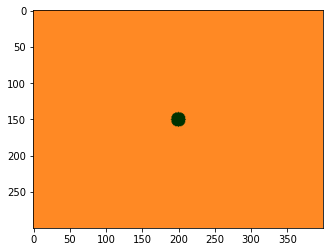

In [10]:
plt.imshow(frame)

# 1B. **Hand Pose**

In [11]:
# initialize model
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(model_complexity=0, max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5)
# process
mp_results = hands.process(img)

In [12]:
# initialize visualization
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [13]:
def visualize_hands(mp_results, img):
    img = img.copy()
    landmarks = mp_results.multi_hand_landmarks
    if landmarks:
        for landmark in landmarks:
            mp_drawing.draw_landmarks(
                img, landmark, mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style())
        # print(landmarks)
    return img

# plt.imshow(visualize_hands(mp_results, img))

# 1C. **Hand Gesture**

Pose based RNN, debouncing, action-based vs. state-based

state가 쉬우니까, continuous pointing based 느낌으로 먼저 ㄱㄱ.

# **2. Optimization**

In [14]:
# a big TODO

ONNX, quantization, 등

global - local kalman filter (camera, in-scene object) assisted residuals-based flicker suppression w/ location estimation

# **3. User Interaction**

## **3A. DearPyGUI**

In [15]:
# setup DearPyGUI
dpg.create_context()
dpg.create_viewport(title='Live Braille 2', width=window_size[0], height=window_size[1])
dpg.setup_dearpygui()
dpg.show_viewport()

In [16]:
# texture registry
with dpg.texture_registry(show=True): # show=True
    dpg.add_raw_texture(width=img.shape[1], height=img.shape[0], default_value=imdpg2(img), format=dpg.mvFormat_Float_rgb, tag="stream_visualization")

## **3B. DPG Windows**

In [17]:
with dpg.window(label="Visualization", tag="visualization_window"):
    dpg.add_image("stream_visualization")
dpg.set_item_pos("visualization_window", (0, 0))

## **3C. DPG Loop**

In [18]:
# %%prun -s cumulative -q -l 10 -T mainloop_profile.txt -D mainloop_profile.pstat 

c = 0; start_time = time.time()


while dpg.is_dearpygui_running():
    if debug: pass
    else: 
        _, raw = cam.read(); raw = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)
        img = cv2.resize(raw, viz_res, interpolation=cv2.INTER_AREA)

    result = paddle.ocr(img)
    frame, sel = process(img, result)

    dpg.set_value("stream_visualization", imdpg2(frame))

    dpg.render_dearpygui_frame()
    c += 1


end_time = time.time()
time_delta = end_time - start_time
dpg.destroy_context()

print("Frames Per Second:", round(c/time_delta, 2))

Frames Per Second: 25.02


Text to speech

Visual description
  - Optimization using ONNX. Someone has probably done it. 